# **Imports library**

In [1]:
import numpy as np  # Fundamental package for scientific computing, provides support for arrays, matrices, and mathematical functions
import pandas as pd  # Powerful data manipulation and analysis library, offers data structures like Series and DataFrame
import os  # Provides a way of using operating system-dependent functionality like reading or writing to the file system
import matplotlib.pyplot as plt  # Plotting library for creating static, animated, and interactive visualizations in Python
import glob  # Used to retrieve files/pathnames matching a specified pattern
import nibabel as nib  # Library for reading and writing medical imaging data, especially in NIfTI format
import cv2  # OpenCV, a library for computer vision tasks, such as image processing and video capture
import imageio  # Library for reading and writing image data, supporting many formats including animated images
from tqdm.notebook import tqdm  # Progress bar library to show loops progress in Jupyter Notebooks
from ipywidgets import *  # Provides interactive HTML widgets for Jupyter notebooks and the IPython kernel
from PIL import Image  # Python Imaging Library, adds image processing capabilities to Python
from fastai.basics import *  # Importing core functionalities of Fastai, a deep learning library
from fastai.vision.all import *  # Importing all functionalities related to computer vision from Fastai
from fastai.data.transforms import *  # Importing data transformation utilities from Fastai
import tensorflow as tf
import wandb # Importing weight and bais module
from wandb.integration.keras import WandbCallback #callback for weight and bais
from tensorflow.keras.callbacks import TensorBoard #callback module for tensorbaord
import datetime

2024-08-28 19:13:34.030950: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 19:13:34.031087: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 19:13:34.158456: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Preparation

In [2]:
# Create a meta file for nii files processing 


file_list = []
for dirname, _, filenames in os.walk('../input/liver-tumor-segmentation'):
    for filename in filenames:
        file_list.append((dirname, filename)) 

for dirname, _, filenames in os.walk('../input/liver-tumor-segmentation-part-2'):
    for filename in filenames:
        file_list.append((dirname, filename)) 

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename']) 
df_files.sort_values(by=['filename'], ascending=True)    

dirname              filename
89       ../input/liver-tumor-segmentation/segmentations    segmentation-0.nii
81       ../input/liver-tumor-segmentation/segmentations    segmentation-1.nii
142      ../input/liver-tumor-segmentation/segmentations   segmentation-10.nii
31       ../input/liver-tumor-segmentation/segmentations  segmentation-100.nii
45       ../input/liver-tumor-segmentation/segmentations  segmentation-101.nii
..                                                   ...                   ...
243  ../input/liver-tumor-segmentation-part-2/volume_pt6         volume-95.nii
222  ../input/liver-tumor-segmentation-part-2/volume_pt6         volume-96.nii
217  ../input/liver-tumor-segmentation-part-2/volume_pt6         volume-97.nii
252  ../input/liver-tumor-segmentation-part-2/volume_pt6         volume-98.nii
231  ../input/liver-tumor-segmentation-part-2/volume_pt6         volume-99.nii

[262 rows x 2 columns]

In [3]:
#split path image and label
df_files["mask_dirname"]  = ""
df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "../input/liver-tumor-segmentation/segmentations"

# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 

df_files

dirname        filename  \
0           ../input/liver-tumor-segmentation/volume_pt1    volume-0.nii   
1           ../input/liver-tumor-segmentation/volume_pt1    volume-1.nii   
2           ../input/liver-tumor-segmentation/volume_pt1   volume-10.nii   
3    ../input/liver-tumor-segmentation-part-2/volume_pt6  volume-100.nii   
4    ../input/liver-tumor-segmentation-part-2/volume_pt8  volume-101.nii   
..                                                   ...             ...   
126  ../input/liver-tumor-segmentation-part-2/volume_pt6   volume-95.nii   
127  ../input/liver-tumor-segmentation-part-2/volume_pt6   volume-96.nii   
128  ../input/liver-tumor-segmentation-part-2/volume_pt6   volume-97.nii   
129  ../input/liver-tumor-segmentation-part-2/volume_pt6   volume-98.nii   
130  ../input/liver-tumor-segmentation-part-2/volume_pt6   volume-99.nii   

                                        mask_dirname         mask_filename  
0    ../input/liver-tumor-segmentation/segmentations    segmentation-0.nii  
1    ../input/liver-tumor-segmentation/segmentations    segmentation-1.nii  
2    ../input/liver-tumor-segmentation/segmentations   segmentation-10.nii  
3    ../input/liver-tumor-segmentation/segmentations  segmentation-100.nii  
4    ../input/liver-tumor-segmentation/segmentations  segmentation-101.nii  
..                                               ...                   ...  
126  ../input/liver-tumor-segmentation/segmentations   segmentation-95.nii  
127  ../input/liver-tumor-segmentation/segmentations   segmentation-96.nii  
128  ../input/liver-tumor-segmentation/segmentations   segmentation-97.nii  
129  ../input/liver-tumor-segmentation/segmentations   segmentation-98.nii  
130  ../input/liver-tumor-segmentation/segmentations   segmentation-99.nii  

[131 rows x 4 columns]

In [4]:
#Reads .nii file and returns pixel array
def read_nii(filepath):
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [5]:
# Read sample
sample = 0
sample_ct = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])

print(f'CT Shape:   {sample_ct.shape}\nMask Shape: {sample_mask.shape}')

CT Shape:   (512, 512, 75)
Mask Shape: (512, 512, 75)


In [6]:
# min and max value
print(np.amin(sample_ct), np.amax(sample_ct))
print(np.amin(sample_mask), np.amax(sample_mask))

-3024.0 1410.0
0.0 2.0


In [7]:
# call name the parts of the people
# Source https://docs.fast.ai/medical.imaging

dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)
#function call liver in .nii file
@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)


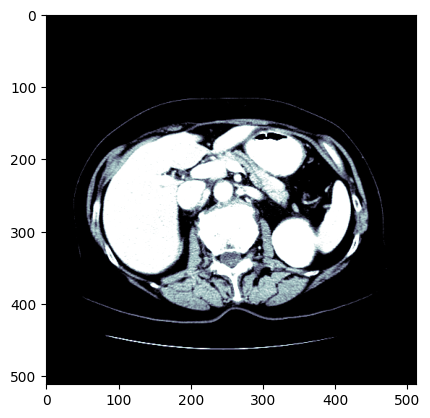

In [8]:
# figure(figsize=(8, 6), dpi=100)
#show
plt.imshow(tensor(sample_ct[..., 55].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

In [9]:
print(type(sample_ct[..., 50]))

<class 'numpy.ndarray'>


In [10]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    
    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')
    
    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    
    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')


    plt.show()

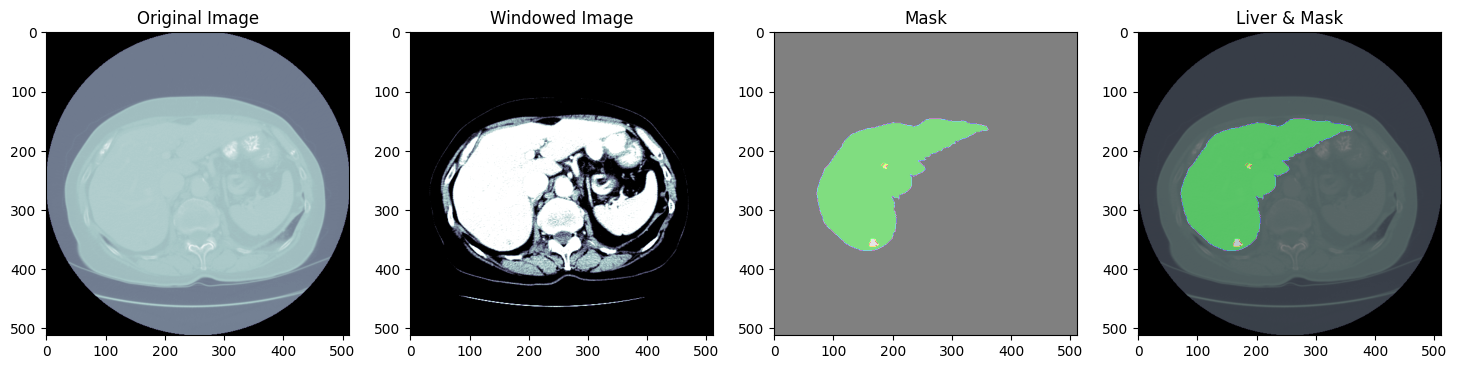

In [11]:
sample=60
sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[...,sample], sample_mask[...,sample]])

In [12]:
# Check the mask values
mask = Image.fromarray(sample_mask[...,sample].astype('uint8'), mode="L")
unique, counts = np.unique(mask, return_counts=True)
print( np.array((unique, counts)).T)

[[     0 231454]
 [     1  30501]
 [     2    189]]


<Axes: >

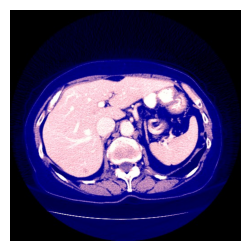

In [13]:
# Preprocessing functions
# Source https://docs.fast.ai/medical.imaging

class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'}

@patch
def freqhist_bins(self:Tensor, n_bins=100):
    ''''"A function to split the range of pixel values into groups, 
    such that each group has around the same number of pixels"'''
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()
    
@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)
    
    
@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=90):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

_,axs=subplots(1,1)

sample_slice.save_jpg('test.jpg', [dicom_windows.liver,dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0])

In [14]:
df_files_1=df_files[0:30]
df_files_1

dirname        filename  \
0          ../input/liver-tumor-segmentation/volume_pt1    volume-0.nii   
1          ../input/liver-tumor-segmentation/volume_pt1    volume-1.nii   
2          ../input/liver-tumor-segmentation/volume_pt1   volume-10.nii   
3   ../input/liver-tumor-segmentation-part-2/volume_pt6  volume-100.nii   
4   ../input/liver-tumor-segmentation-part-2/volume_pt8  volume-101.nii   
5   ../input/liver-tumor-segmentation-part-2/volume_pt8  volume-102.nii   
6   ../input/liver-tumor-segmentation-part-2/volume_pt8  volume-103.nii   
7   ../input/liver-tumor-segmentation-part-2/volume_pt8  volume-104.nii   
8   ../input/liver-tumor-segmentation-part-2/volume_pt8  volume-105.nii   
9   ../input/liver-tumor-segmentation-part-2/volume_pt8  volume-106.nii   
10  ../input/liver-tumor-segmentation-part-2/volume_pt8  volume-107.nii   
11  ../input/liver-tumor-segmentation-part-2/volume_pt8  volume-108.nii   
12  ../input/liver-tumor-segmentation-part-2/volume_pt8  volume-109.nii   
13         ../input/liver-tumor-segmentation/volume_pt2   volume-11.nii   
14  ../input/liver-tumor-segmentation-part-2/volume_pt8  volume-110.nii   
15  ../input/liver-tumor-segmentation-part-2/volume_pt8  volume-111.nii   
16  ../input/liver-tumor-segmentation-part-2/volume_pt8  volume-112.nii   
17  ../input/liver-tumor-segmentation-part-2/volume_pt8  volume-113.nii   
18  ../input/liver-tumor-segmentation-part-2/volume_pt8  volume-114.nii   
19  ../input/liver-tumor-segmentation-part-2/volume_pt8  volume-115.nii   
20  ../input/liver-tumor-segmentation-part-2/volume_pt8  volume-116.nii   
21  ../input/liver-tumor-segmentation-part-2/volume_pt8  volume-117.nii   
22  ../input/liver-tumor-segmentation-part-2/volume_pt8  volume-118.nii   
23  ../input/liver-tumor-segmentation-part-2/volume_pt8  volume-119.nii   
24         ../input/liver-tumor-segmentation/volume_pt2   volume-12.nii   
25  ../input/liver-tumor-segmentation-part-2/volume_pt8  volume-120.nii   
26  ../input/liver-tumor-segmentation-part-2/volume_pt8  volume-121.nii   
27  ../input/liver-tumor-segmentation-part-2/volume_pt8  volume-122.nii   
28  ../input/liver-tumor-segmentation-part-2/volume_pt8  volume-123.nii   
29  ../input/liver-tumor-segmentation-part-2/volume_pt8  volume-124.nii   

                                       mask_dirname         mask_filename  
0   ../input/liver-tumor-segmentation/segmentations    segmentation-0.nii  
1   ../input/liver-tumor-segmentation/segmentations    segmentation-1.nii  
2   ../input/liver-tumor-segmentation/segmentations   segmentation-10.nii  
3   ../input/liver-tumor-segmentation/segmentations  segmentation-100.nii  
4   ../input/liver-tumor-segmentation/segmentations  segmentation-101.nii  
5   ../input/liver-tumor-segmentation/segmentations  segmentation-102.nii  
6   ../input/liver-tumor-segmentation/segmentations  segmentation-103.nii  
7   ../input/liver-tumor-segmentation/segmentations  segmentation-104.nii  
8   ../input/liver-tumor-segmentation/segmentations  segmentation-105.nii  
9   ../input/liver-tumor-segmentation/segmentations  segmentation-106.nii  
10  ../input/liver-tumor-segmentation/segmentations  segmentation-107.nii  
11  ../input/liver-tumor-segmentation/segmentations  segmentation-108.nii  
12  ../input/liver-tumor-segmentation/segmentations  segmentation-109.nii  
13  ../input/liver-tumor-segmentation/segmentations   segmentation-11.nii  
14  ../input/liver-tumor-segmentation/segmentations  segmentation-110.nii  
15  ../input/liver-tumor-segmentation/segmentations  segmentation-111.nii  
16  ../input/liver-tumor-segmentation/segmentations  segmentation-112.nii  
17  ../input/liver-tumor-segmentation/segmentations  segmentation-113.nii  
18  ../input/liver-tumor-segmentation/segmentations  segmentation-114.nii  
19  ../input/liver-tumor-segmentation/segmentations  segmentation-115.nii  
20  ../input/liver-tumor-segmentation/segmentations  segmentation-116.nii  
21  ../input/liver-tumor-segmentation/segmentation

In [15]:
import random
import os
from tqdm import tqdm
from pathlib import Path
import numpy as np
from PIL import Image

# Define whether to generate JPG files or use pre-saved ones
GENERATE_JPG_FILES = True  # Warning: generation can take ~30 minutes (depends on RAM)

if GENERATE_JPG_FILES:
    # Set the current path
    path = Path(".")

    # Create directories for training images and masks if they don't exist
    os.makedirs('train_images', exist_ok=True)
    os.makedirs('train_masks', exist_ok=True)

    # Randomly select half of the indices from the dataframe
    random_indices = random.sample(range(len(df_files)), len(df_files) // 2)

    # Loop through the selected indices to process the nii files
    for ii in tqdm(random_indices):  # Take 1/2 nii files for training
        # Read the current CT scan and corresponding mask
        curr_ct = read_nii(df_files.loc[ii, 'dirname'] + "/" + df_files.loc[ii, 'filename'])
        curr_mask = read_nii(df_files.loc[ii, 'mask_dirname'] + "/" + df_files.loc[ii, 'mask_filename'])
        
        # Extract the file name without the extension
        curr_file_name = str(df_files.loc[ii, 'filename']).split('.')[0]
        
        # Get the number of slices in the CT scan
        curr_dim = curr_ct.shape[2]  # Shape is (512, 512, curr_dim)

        # Loop through every 2nd slice to save as images for training
        for curr_slice in range(0, curr_dim, 2):
            data = tensor(curr_ct[..., curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[..., curr_slice].astype('uint8'), mode="L")
            
            # Save the CT slice as a JPG image
            data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver, dicom_windows.custom])
            
            # Save the corresponding mask as a PNG image
            mask.save(f"train_masks/{curr_file_name}_slice_{curr_slice}_mask.png")
else:
    # Set the path to the pre-saved kernel output if not generating new files
    path = Path("liver-segmentation-with-fastai-v2")


100%|██████████| 65/65 [13:49<00:00, 12.76s/it]


In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
# Set the directories
images_dir = 'train_images'
masks_dir = 'train_masks'

# Get the list of image file names
all_image_file_names = sorted(os.listdir(images_dir))

# Randomly select 9000 images
selected_image_file_names = random.sample(all_image_file_names, 9000)

# Load selected images and masks with resizing
target_size = (128, 128)
images = [np.array(Image.open(os.path.join(images_dir, fname)).resize(target_size)) for fname in selected_image_file_names]

# Adjust file extension for masks
mask_file_names = [fname.replace('.jpg', '_mask.png') for fname in selected_image_file_names]
masks = [np.array(Image.open(os.path.join(masks_dir, fname)).resize(target_size)) for fname in mask_file_names]

# Convert the lists to numpy arrays
images = np.array(images)
masks = np.array(masks)

# Normalize images to [0, 1]
images = images / 255.0

# Reshape masks to include a channel dimension
masks = masks.reshape((masks.shape[0], masks.shape[1], masks.shape[2], 1))

# Convert masks to one-hot encoding
masks = to_categorical(masks, num_classes=3)

# Print the shapes to confirm changes
print("Images shape:", images.shape)
print("Masks shape:", masks.shape)

Images shape: (9000, 128, 128, 3)
Masks shape: (9000, 128, 128, 3)


In [17]:
# Split the data into training, validation, and test sets
# 70% training, 20% validation, 10% test
x_train, x_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.3, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=1/3, random_state=42)

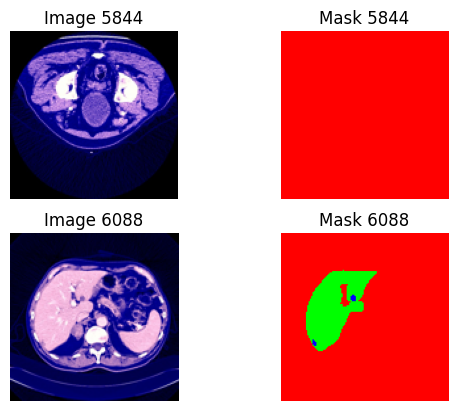

In [18]:
import matplotlib.pyplot as plt

# Function to display images and masks
def display_images_and_masks(images, masks, num_samples=2):
    # Randomly select samples
    sample_indices = random.sample(range(images.shape[0]), num_samples)

    for i in range(num_samples):
        index = sample_indices[i]

        # Display the image
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(images[index])
        plt.title("Image {}".format(index))
        plt.axis("off")

        # Display the mask
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(masks[index].squeeze(), cmap='gray')
        plt.title("Mask {}".format(index))
        plt.axis("off")
    plt.show()

    
# Display two random images and masks
display_images_and_masks(x_train, y_train)


In [19]:
y_train.shape, x_train.shape

((6300, 128, 128, 3), (6300, 128, 128, 3))

In [20]:
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,UpSampling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping




# Define Dice coefficient as a metric
def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1)
    return (2. * intersection + smooth) / (union + smooth)

# Define Mean IoU for binary masks
def mean_iou(y_true, y_pred, smooth=1):
    y_pred = K.cast(y_pred > 0.5, K.floatx())
    intersect = K.sum(y_true * y_pred, axis=[0, -1, -2])
    union = K.sum(y_true + y_pred, axis=[0, -1, -2])
    return (intersect + smooth) / (union - intersect + smooth)


def accuracy(y_true, y_pred):
    y_true = K.cast(y_true, K.floatx())
    y_pred = K.cast(y_pred > 0.5, K.floatx())
    correct_predictions = K.sum(K.cast(K.equal(y_true, y_pred), K.floatx()), axis=[0, -1, -2])
    total_predictions = K.cast(K.prod(K.shape(y_true)[:-1]), K.floatx())
    return correct_predictions / total_predictions

def precision(y_true, y_pred):
    y_true = K.cast(y_true, K.floatx())
    y_pred = K.cast(y_pred > 0.5, K.floatx())
    true_positives = K.sum(y_true * y_pred, axis=[0, -1, -2])
    predicted_positives = K.sum(y_pred, axis=[0, -1, -2])
    return true_positives / (predicted_positives + K.epsilon())

def recall(y_true, y_pred):
    y_true = K.cast(y_true, K.floatx())
    y_pred = K.cast(y_pred > 0.5, K.floatx())
    true_positives = K.sum(y_true * y_pred, axis=[0, -1, -2])
    possible_positives = K.sum(y_true, axis=[0, -1, -2])
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    y_true = K.cast(y_true, K.floatx())
    y_pred = K.cast(y_pred > 0.5, K.floatx())
    true_negatives = K.sum((1 - y_true) * (1 - y_pred), axis=[0, -1, -2])
    possible_negatives = K.sum(1 - y_true, axis=[0, -1, -2])
    return true_negatives / (possible_negatives + K.epsilon())

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec + K.epsilon())

def jaccard_index(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, K.floatx())
    y_pred = K.cast(y_pred > 0.5, K.floatx())
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    union = K.sum(y_true + y_pred, axis=[0, -1, -2]) - intersection
    return (intersection + smooth) / (union + smooth)


In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, UpSampling2D, Conv2DTranspose
from tensorflow.keras.models import Model


def conv_block(x, filters, kernel_size=3, stride=1, padding='same'):
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding=padding, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

def residual_block(x, filters, kernel_size=3, stride=1, padding='same'):
    shortcut = x
    
    # First Convolution Block
    x = conv_block(x, filters, kernel_size, stride, padding)
    # Second Convolution Block (always stride=1 here)
    x = conv_block(x, filters, kernel_size, stride=1, padding=padding)
    
    # Adjust shortcut if dimensions do not match
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    # Adding the shortcut connection to the output
    x = Add()([x, shortcut])
    return x


def resnet34_model(input_shape=(128, 128, 3), num_classes=3):
    inputs = Input(input_shape)
    
    # Initial Convolution
    x = Conv2D(64, (7, 7), strides=2, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)
    
    # Residual Blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    
    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512)
    x = residual_block(x, 512)
    
    # Upsampling to match the original input dimensions
    x = UpSampling2D(size=(2, 2))(x)  # From (4, 4) to (8, 8)
    x = UpSampling2D(size=(2, 2))(x)  # From (8, 8) to (16, 16)
    x = UpSampling2D(size=(2, 2))(x)  # From (16, 16) to (32, 32)
    x = UpSampling2D(size=(2, 2))(x)  # From (32, 32) to (64, 64)
    x = UpSampling2D(size=(2, 2))(x)  # From (64, 64) to (128, 128)
    
    # Final Convolution to produce the segmentation mask
    x = Conv2D(num_classes, (1, 1), padding='same', activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=x)
    
    return model


In [22]:
# Example usage
model = resnet34_model(input_shape=(128, 128, 3), num_classes=3)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      9,408 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     36,864 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     36,864 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ re_lu_2[0][0],    │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     36,864 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     36,864 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_4[0][0]  

 Total params: 21,377,475 (81.55 MB)

 Trainable params: 21,360,195 (81.48 MB)

 Non-trainable params: 17,280 (67.50 KB)

In [23]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)


In [24]:

# Compile the model with categorical crossentropy loss for multi-class segmentation
model.compile(optimizer=Adam(learning_rate=0.001),
               loss='categorical_crossentropy',
               metrics=[dice_coefficient, mean_iou])

# Define callbacks
checkpoint = ModelCheckpoint("resnet34_model.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')




In [25]:
import tensorflow as tf

# Check if TensorFlow is using GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("CUDA and cuDNN are installed and TensorFlow can access the GPU.")
    print(f"Number of GPUs available: {len(gpus)}")
    for gpu in gpus:
        print(f"GPU: {gpu.name}")
else:
    print("CUDA and cuDNN are not detected, or TensorFlow cannot access the GPU.")

# Print CUDA and cuDNN versions if available
print("TensorFlow version:", tf.__version__)
print("CUDA version:", tf.sysconfig.get_build_info().get('cuda_version'))
print("cuDNN version:", tf.sysconfig.get_build_info().get('cudnn_version'))


CUDA and cuDNN are installed and TensorFlow can access the GPU.
Number of GPUs available: 2
GPU: /physical_device:GPU:0
GPU: /physical_device:GPU:1
TensorFlow version: 2.15.0
CUDA version: 12.2
cuDNN version: 8


In [26]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

# Define the TensorBoard callback
tensorboard_callback1 = TensorBoard(
    log_dir='./logs',             # Directory where the logs will be saved
    histogram_freq=1,             # Frequency (in epochs) at which to compute activation and weight histograms for the layers of the model
    write_graph=True,             # Whether to visualize the graph in TensorBoard
    write_images=True             # Whether to write model weights to visualize as image in TensorBoard
)


In [27]:
# Train the model
history1 = model.fit(x_train, y_train, epochs=10, batch_size=1,
                      validation_data=(x_valid, y_valid), 
                      callbacks=[checkpoint, early_stopping,tensorboard_callback1])

Epoch 1/10


I0000 00:00:1724873484.812829     143 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6299/6300 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - dice_coefficient: 0.9756 - loss: 0.1287 - mean_iou: 0.9559
Epoch 1: val_loss improved from inf to 0.14841, saving model to resnet34_model.keras
6300/6300 ━━━━━━━━━━━━━━━━━━━━ 236s 32ms/step - dice_coefficient: 0.9756 - loss: 0.1287 - mean_iou: 0.9559 - val_dice_coefficient: 0.9823 - val_loss: 0.1484 - val_mean_iou: 0.9618
Epoch 2/10
6299/6300 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - dice_coefficient: 0.9812 - loss: 0.0516 - mean_iou: 0.9673
Epoch 2: val_loss improved from 0.14841 to 0.07573, saving model to resnet34_model.keras
6300/6300 ━━━━━━━━━━━━━━━━━━━━ 196s 31ms/step - dice_coefficient: 0.9812 - loss: 0.0516 - mean_iou: 0.9673 - val_dice_coefficient: 0.9696 - val_loss: 0.0757 - val_mean_iou: 0.9545
Epoch 3/10
6299/6300 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - dice_coefficient: 0.9813 - loss: 0.0482 - mean_iou: 0.9670
Epoch 3: val_loss did not improve from 0.07573
6300/6300 ━━━━━━━━━━━━━━━━━━━━ 199s 31ms/step - dice_coefficient: 0.9813 - loss: 0

In [29]:
# Evaluate the model
test_scores1 = model.evaluate(x_test, y_test)
print(f"Test Dice Coefficient: {test_scores1[1]}")
print(f"Test Mean IoU: {test_scores1[2]}")

# Log to Weights & Biases
# wandb.log({
#     "Test Dice Coefficient": test_scores1[1],
#     "Test Mean IoU": test_scores1[2]
# })

29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - dice_coefficient: 0.9836 - loss: 0.0589 - mean_iou: 0.9627
Test Dice Coefficient: 0.9834954142570496
Test Mean IoU: 0.9628242254257202


In [33]:
# Predict on the test set
y_pred = model.predict(x_test)

# Dictionary of additional metrics
additional_metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'specificity': specificity,
    'f1_score': f1_score,
    'jaccard_index': jaccard_index
}
# Create a file writer for the log directory
# file_writer = tf.summary.create_file_writer(log_dir1 + "/metrics")

for metric_name, metric_func in additional_metrics.items():
    score = metric_func(y_test, y_pred)
    aggregated_score = np.mean(score.numpy())  # Calculate the mean across all classes
    print(f"Test {metric_name}: {aggregated_score}")
#     wandb.log({f"Test {metric_name}": aggregated_score})
    tf.summary.scalar(f"Test {metric_name}", aggregated_score, step=0)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Test accuracy: 0.02312985062599182
Test precision: 0.9804413318634033
Test recall: 0.9801715612411499
Test specificity: 0.9902245998382568
Test f1_score: 0.9803063869476318
Test jaccard_index: 0.9621453881263733


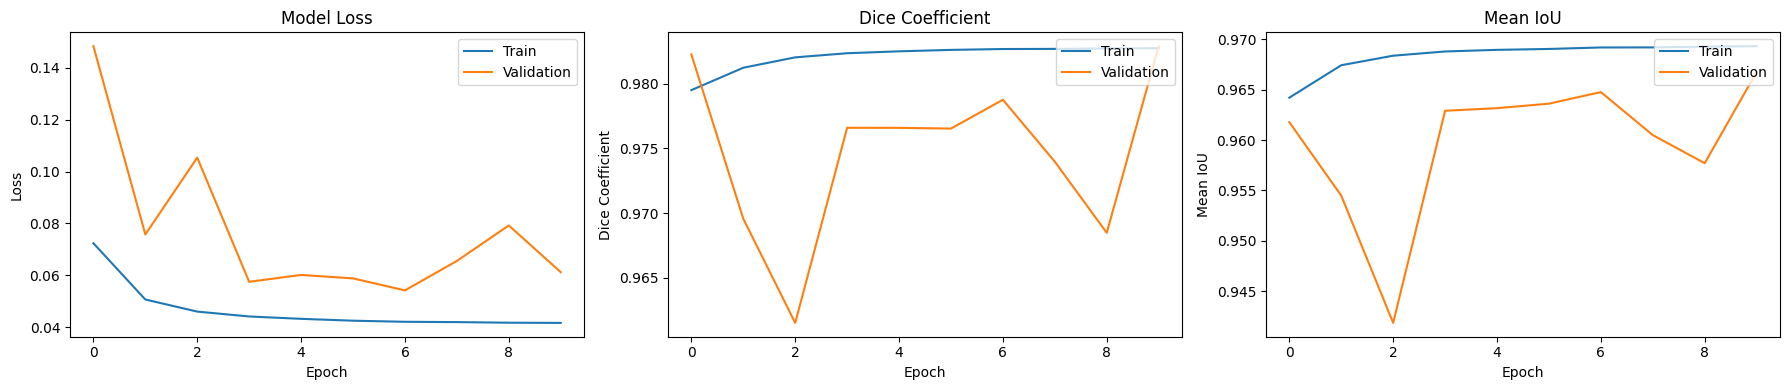

In [34]:
# Function to plot training and validation metrics
def plot_history(history):
    # Create a figure for plotting
    plt.figure(figsize=(18, 4))

    # Plot training & validation loss values
    plt.subplot(1, 3, 1)  # Adjusted to 1 row, 3 columns
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation Dice coefficient values
    plt.subplot(1, 3, 2)  # Adjusted to 1 row, 3 columns
    plt.plot(history.history['dice_coefficient'])
    plt.plot(history.history['val_dice_coefficient'])
    plt.title('Dice Coefficient')
    plt.ylabel('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation IoU values
    plt.subplot(1, 3, 3)  # New subplot for IoU
    plt.plot(history.history['mean_iou'])
    plt.plot(history.history['val_mean_iou'])
    plt.title('Mean IoU')
    plt.ylabel('Mean IoU')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Call the function with the training history
plot_history(history1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


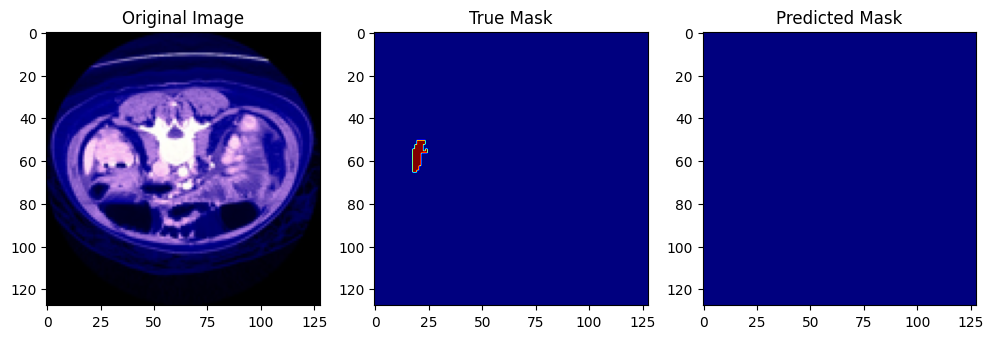

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Get a random index from the test dataset
image_index = random.randint(0, len(x_test) - 1)

# Load the image and true mask
input_image = x_test[image_index]
true_mask = y_test[image_index]

# Obtain the predicted mask from model1
predicted_mask = model.predict(np.expand_dims(input_image, axis=0))[0]

# Convert the predicted mask to class labels using argmax
predicted_mask_classes = np.argmax(predicted_mask, axis=-1)

# Convert the true mask to class labels using argmax
true_mask_classes = np.argmax(true_mask, axis=-1)

# Plotting
plt.figure(figsize=(12, 4))

# Plot original image
plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title('Original Image')

# Plot true mask with a colormap to differentiate liver and tumor
plt.subplot(1, 3, 2)
plt.imshow(true_mask_classes, cmap='jet')  # Use 'jet' colormap for different classes
plt.title('True Mask')

# Plot predicted mask with a colormap to differentiate liver and tumor
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_classes, cmap='jet')  # Use 'jet' colormap for different classes
plt.title('Predicted Mask')

plt.show()


In [69]:
import matplotlib.pyplot as plt

# Function to log sample images and masks to Weights & Biases
def log_images_to_wandb(x_test, y_test, y_pred, num_samples=3):
    sample_indices = random.sample(range(len(x_test)), num_samples)
    for i in sample_indices:
        input_image = x_test[i]
        true_mask = y_test[i]
        predicted_mask = y_pred[i]

        # Plot images
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(input_image)
        axes[0].set_title('Original Image')
        axes[1].imshow(true_mask[:, :, 0], cmap='gray')
        axes[1].set_title('True Mask')
        axes[2].imshow(predicted_mask[:, :, 0], cmap='gray')
        axes[2].set_title('Predicted Mask')
        wandb.log({"example_image": wandb.Image(fig)})
        plt.close(fig)

# Log images after model prediction
y_pred = model.predict(x_test)
# log_images_to_wandb(x_test, y_test, y_pred)


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


In [71]:
import tensorflow as tf

# Function to log sample images and masks to TensorBoard
def log_images_to_tensorboard(x_test, y_test, y_pred, num_samples=3, log_dir1="logs/fit"):
    sample_indices = random.sample(range(len(x_test)), num_samples)
    file_writer = tf.summary.create_file_writer(log_dir1 + "/images")
    with file_writer.as_default():
        for i in sample_indices:
            input_image = x_test[i]
            true_mask = y_test[i]
            predicted_mask = y_pred[i]

            # Plot images
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            axes[0].imshow(input_image)
            axes[0].set_title('Original Image')
            axes[1].imshow(true_mask[:, :, 0], cmap='gray')
            axes[1].set_title('True Mask')
            axes[2].imshow(predicted_mask[:, :, 0], cmap='gray')
            axes[2].set_title('Predicted Mask')

            # Convert plot to image and log to TensorBoard
            buf = io.BytesIO()
            plt.savefig(buf, format='png')
            buf.seek(0)
            image = tf.image.decode_png(buf.getvalue(), channels=4)
            image = tf.expand_dims(image, 0)
            tf.summary.image(f"Example Image {i}", image, step=0)
            plt.close(fig)

# Log images after model prediction
y_pred = model.predict(x_test)
log_images_to_tensorboard(x_test, y_test, y_pred)


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
